In [1]:
import torch
from torch.utils.data import Dataset
import torchvision
from PIL import Image
import requests
from io import BytesIO
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

In [6]:


class LazyRotationImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super(LazyRotationImageDataset, self).__init__()
        self.data = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in sorted(filenames)]
        self.rotations = [0, 90, 180, 270]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        rotation_idx = torch.randint(0, 4, (1,)).item()  # Random index for rotation
        rotation_angle = self.rotations[rotation_idx]  # Corresponding rotation angle

        rotation_transform = transforms.Compose([
            transforms.RandomRotation([rotation_angle, rotation_angle], expand=True),
            transforms.ToTensor()
        ])

        rotated_image = rotation_transform(image)  # Applies the selected rotation
        return rotated_image, rotation_idx

# Example usage
dataset = LazyRotationImageDataset("../../images")
# dataset = LazyRotationImageDataset("/content/")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# Now you can use this dataloader in your training loop

In [8]:
len(dataset)

3000

In [9]:
import os
import shutil

dir_path = "../../"  # replace with your directory path
image_dir = os.path.join(dir_path, "images")

# Create the images subdirectory if it doesn't exist
os.makedirs(image_dir, exist_ok=True)

# Iterate over all files in the directory
for file in os.listdir(dir_path):
    # If the file is a .jpg image
    if file.endswith(".jpg"):
        # Move it to the images subdirectory
        shutil.move(os.path.join(dir_path, file), os.path.join(image_dir, file))

In [10]:
from tqdm import tqdm

# Model modification to predict rotation
class RotationPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)  # Predicting 4 rotation classes

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RotationPredictor().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
epochs = 20
for epoch in range(epochs):
  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

torch.save(model.state_dict(), "model.pt")

# Now the model is fine-tuned to predict rotations, which also improves its feature extraction capability

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:35<00:00,  2.64it/s]


Epoch 1/20, Loss: 0.448567271232605


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.08it/s]


Epoch 2/20, Loss: 0.2625769078731537


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.08it/s]


Epoch 3/20, Loss: 0.2400233894586563


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch 4/20, Loss: 0.2722925543785095


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.08it/s]


Epoch 5/20, Loss: 0.4656275510787964


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch 6/20, Loss: 0.39582833647727966


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch 7/20, Loss: 0.29285529255867004


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch 8/20, Loss: 0.2359888106584549


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch 9/20, Loss: 0.4874532222747803


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch 10/20, Loss: 0.1005578264594078


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch 11/20, Loss: 0.127684086561203


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch 12/20, Loss: 0.16921967267990112


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch 13/20, Loss: 0.05768834426999092


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.05it/s]


Epoch 14/20, Loss: 0.3148510754108429


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch 15/20, Loss: 0.10876234620809555


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch 16/20, Loss: 0.11611545085906982


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.05it/s]


Epoch 17/20, Loss: 0.04371531680226326


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.05it/s]


Epoch 18/20, Loss: 0.10252238065004349


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.05it/s]


Epoch 19/20, Loss: 0.13921289145946503


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.05it/s]


Epoch 20/20, Loss: 0.052675943821668625


In [34]:
# Load the entire model (architecture + weights)
#model = torch.load('model.pt')

In [11]:
def count_parameters(model):
	return sum(p.numel() for p in model.parameters())


In [12]:
count_parameters(model)

11178564

In [13]:
model.eval()
import copy

resnet_pretrained = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_pretrained = nn.Sequential(*list(resnet_pretrained.children())[:-4], nn.AdaptiveAvgPool2d((1, 1)))
resnet_pretrained = torch.quantization.quantize_dynamic(
	resnet_pretrained, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
)


model_finetunned = copy.deepcopy(model.resnet)
model_finetunned = nn.Sequential(*list(model_finetunned.children())[:-4], nn.AdaptiveAvgPool2d((1, 1)))
model_finetunned = torch.quantization.quantize_dynamic(
	model_finetunned, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
)

count_parameters(resnet_pretrained), count_parameters(model_finetunned)

(683072, 683072)

In [14]:
model

RotationPredictor(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [15]:
resnet_pretrained

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
model(dataset[0][0].to(device).unsqueeze(0))

tensor([[-4.5381,  5.0973, -2.3276, -0.5185]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [17]:
resnet_pretrained = resnet_pretrained.to("cpu")
features_pretrained = torch.zeros((len(dataset), 128))


In [18]:
for i, (images, labels) in tqdm(enumerate(dataloader)):
    print(f"{i}")
    # images = images
    # labels = labels
    outputs = resnet_pretrained(images).squeeze().detach()
    features_pretrained[i * 32: i * 32 + len(images)] = outputs

0it [00:00, ?it/s]

0


1it [00:01,  1.85s/it]

1


2it [00:02,  1.39s/it]

2


3it [00:04,  1.26s/it]

3


4it [00:05,  1.18s/it]

4


5it [00:06,  1.15s/it]

5


6it [00:07,  1.12s/it]

6


7it [00:08,  1.10s/it]

7


8it [00:09,  1.10s/it]

8


9it [00:10,  1.09s/it]

9


10it [00:11,  1.10s/it]

10


11it [00:12,  1.09s/it]

11


12it [00:13,  1.10s/it]

12


13it [00:14,  1.10s/it]

13


14it [00:16,  1.13s/it]

14


15it [00:17,  1.12s/it]

15


16it [00:18,  1.12s/it]

16


17it [00:19,  1.15s/it]

17


18it [00:20,  1.15s/it]

18


19it [00:21,  1.13s/it]

19


20it [00:22,  1.11s/it]

20


21it [00:23,  1.10s/it]

21


22it [00:25,  1.11s/it]

22


23it [00:26,  1.10s/it]

23


24it [00:27,  1.10s/it]

24


25it [00:28,  1.10s/it]

25


26it [00:29,  1.11s/it]

26


27it [00:30,  1.10s/it]

27


28it [00:31,  1.11s/it]

28


29it [00:32,  1.13s/it]

29


30it [00:33,  1.12s/it]

30


31it [00:35,  1.12s/it]

31


32it [00:36,  1.13s/it]

32


33it [00:37,  1.17s/it]

33


34it [00:38,  1.19s/it]

34


35it [00:39,  1.20s/it]

35


36it [00:41,  1.20s/it]

36


37it [00:42,  1.22s/it]

37


38it [00:43,  1.23s/it]

38


39it [00:44,  1.25s/it]

39


40it [00:46,  1.24s/it]

40


41it [00:47,  1.24s/it]

41


42it [00:48,  1.22s/it]

42


43it [00:49,  1.21s/it]

43


44it [00:50,  1.21s/it]

44


45it [00:52,  1.21s/it]

45


46it [00:53,  1.20s/it]

46


47it [00:54,  1.21s/it]

47


48it [00:55,  1.21s/it]

48


49it [00:57,  1.25s/it]

49


50it [00:58,  1.24s/it]

50


51it [00:59,  1.21s/it]

51


52it [01:00,  1.20s/it]

52


53it [01:01,  1.21s/it]

53


54it [01:03,  1.21s/it]

54


55it [01:04,  1.20s/it]

55


56it [01:05,  1.22s/it]

56


57it [01:06,  1.21s/it]

57


58it [01:07,  1.21s/it]

58


59it [01:09,  1.21s/it]

59


60it [01:10,  1.19s/it]

60


61it [01:11,  1.19s/it]

61


62it [01:12,  1.19s/it]

62


63it [01:13,  1.19s/it]

63


64it [01:15,  1.21s/it]

64


65it [01:16,  1.21s/it]

65


66it [01:17,  1.22s/it]

66


67it [01:18,  1.23s/it]

67


68it [01:19,  1.20s/it]

68


69it [01:21,  1.20s/it]

69


70it [01:22,  1.20s/it]

70


71it [01:23,  1.19s/it]

71


72it [01:24,  1.17s/it]

72


73it [01:25,  1.18s/it]

73


74it [01:27,  1.18s/it]

74


75it [01:28,  1.19s/it]

75


76it [01:29,  1.18s/it]

76


77it [01:30,  1.19s/it]

77


78it [01:31,  1.19s/it]

78


79it [01:33,  1.20s/it]

79


80it [01:34,  1.20s/it]

80


81it [01:35,  1.19s/it]

81


82it [01:36,  1.18s/it]

82


83it [01:37,  1.18s/it]

83


84it [01:38,  1.19s/it]

84


85it [01:40,  1.18s/it]

85


86it [01:41,  1.18s/it]

86


87it [01:42,  1.18s/it]

87


88it [01:43,  1.17s/it]

88


89it [01:44,  1.17s/it]

89


90it [01:45,  1.16s/it]

90


91it [01:47,  1.18s/it]

91


92it [01:48,  1.19s/it]

92


93it [01:49,  1.19s/it]

93


94it [01:50,  1.18s/it]


In [19]:
features_pretrained
torch.save(features_pretrained, "tens.pt")

In [21]:
def get_image_names(directory):
    image_extensions = '.jpg'
    image_names = []
    for filename in sorted(os.listdir(directory)):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_names.append(filename)
    return image_names

directory = "../../images"
image_names = get_image_names(directory)
print(image_names)

['0_0.jpg', '0_1.jpg', '0_2.jpg', '1000_0.jpg', '1000_1.jpg', '1000_2.jpg', '1001_0.jpg', '1001_1.jpg', '1001_2.jpg', '1002_0.jpg', '1002_1.jpg', '1002_2.jpg', '1003_0.jpg', '1003_1.jpg', '1003_2.jpg', '1004_0.jpg', '1004_1.jpg', '1004_2.jpg', '1005_0.jpg', '1005_1.jpg', '1005_2.jpg', '1006_0.jpg', '1006_1.jpg', '1007_0.jpg', '1007_1.jpg', '1007_2.jpg', '1008_0.jpg', '1008_1.jpg', '1008_2.jpg', '1009_0.jpg', '1009_1.jpg', '1009_2.jpg', '100_0.jpg', '100_1.jpg', '100_2.jpg', '1010_0.jpg', '1010_1.jpg', '1010_2.jpg', '1011_0.jpg', '1011_1.jpg', '1011_2.jpg', '1012_0.jpg', '1012_1.jpg', '1012_2.jpg', '1013_0.jpg', '1013_1.jpg', '1013_2.jpg', '1014_0.jpg', '1014_1.jpg', '1014_2.jpg', '1015_0.jpg', '1015_1.jpg', '1015_2.jpg', '1017_0.jpg', '1017_1.jpg', '1017_2.jpg', '1018_0.jpg', '1019_0.jpg', '1019_1.jpg', '1019_2.jpg', '101_0.jpg', '101_1.jpg', '101_2.jpg', '1020_0.jpg', '1020_1.jpg', '1020_2.jpg', '1021_0.jpg', '1021_1.jpg', '1021_2.jpg', '1022_0.jpg', '1022_1.jpg', '1022_2.jpg', '1023_

In [22]:
pretrained_matrix = []

for image, vector in zip(image_names, features_pretrained):
    pretrained_matrix.append([image, vector])

In [23]:
model_finetunned = model_finetunned.to("cpu")
features_finetunning = torch.zeros((len(dataset), 128))


In [24]:
for i, (images, labels) in tqdm(enumerate(dataloader)):
    print(f"{i}")
    # images = images
    # labels = labels
    outputs = model_finetunned(images).squeeze().detach()
    features_finetunning[i * 32: i * 32 + len(images)] = outputs

0it [00:00, ?it/s]

0


1it [00:01,  1.23s/it]

1


2it [00:02,  1.15s/it]

2


3it [00:03,  1.15s/it]

3


4it [00:04,  1.12s/it]

4


5it [00:05,  1.11s/it]

5


6it [00:06,  1.10s/it]

6


7it [00:07,  1.11s/it]

7


8it [00:08,  1.10s/it]

8


9it [00:09,  1.08s/it]

9


10it [00:11,  1.09s/it]

10


11it [00:12,  1.08s/it]

11


12it [00:13,  1.08s/it]

12


13it [00:14,  1.08s/it]

13


14it [00:15,  1.10s/it]

14


15it [00:16,  1.08s/it]

15


16it [00:17,  1.10s/it]

16


17it [00:18,  1.13s/it]

17


18it [00:20,  1.15s/it]

18


19it [00:21,  1.17s/it]

19


20it [00:22,  1.18s/it]

20


21it [00:23,  1.18s/it]

21


22it [00:24,  1.19s/it]

22


23it [00:26,  1.20s/it]

23


24it [00:27,  1.19s/it]

24


25it [00:28,  1.19s/it]

25


26it [00:29,  1.19s/it]

26


27it [00:30,  1.19s/it]

27


28it [00:31,  1.19s/it]

28


29it [00:33,  1.20s/it]

29


30it [00:34,  1.20s/it]

30


31it [00:35,  1.23s/it]

31


32it [00:36,  1.22s/it]

32


33it [00:38,  1.22s/it]

33


34it [00:39,  1.21s/it]

34


35it [00:40,  1.21s/it]

35


36it [00:41,  1.18s/it]

36


37it [00:42,  1.18s/it]

37


38it [00:44,  1.19s/it]

38


39it [00:45,  1.20s/it]

39


40it [00:46,  1.18s/it]

40


41it [00:47,  1.20s/it]

41


42it [00:48,  1.18s/it]

42


43it [00:49,  1.19s/it]

43


44it [00:51,  1.19s/it]

44


45it [00:52,  1.20s/it]

45


46it [00:53,  1.23s/it]

46


47it [00:54,  1.23s/it]

47


48it [00:56,  1.23s/it]

48


49it [00:57,  1.21s/it]

49


50it [00:58,  1.23s/it]

50


51it [00:59,  1.22s/it]

51


52it [01:00,  1.21s/it]

52


53it [01:02,  1.20s/it]

53


54it [01:03,  1.22s/it]

54


55it [01:04,  1.24s/it]

55


56it [01:05,  1.22s/it]

56


57it [01:07,  1.22s/it]

57


58it [01:08,  1.20s/it]

58


59it [01:09,  1.20s/it]

59


60it [01:10,  1.19s/it]

60


61it [01:11,  1.21s/it]

61


62it [01:13,  1.22s/it]

62


63it [01:14,  1.20s/it]

63


64it [01:15,  1.20s/it]

64


65it [01:16,  1.19s/it]

65


66it [01:17,  1.21s/it]

66


67it [01:19,  1.21s/it]

67


68it [01:20,  1.21s/it]

68


69it [01:21,  1.21s/it]

69


70it [01:22,  1.20s/it]

70


71it [01:23,  1.19s/it]

71


72it [01:25,  1.19s/it]

72


73it [01:26,  1.19s/it]

73


74it [01:27,  1.19s/it]

74


75it [01:28,  1.19s/it]

75


76it [01:29,  1.23s/it]

76


77it [01:31,  1.22s/it]

77


78it [01:32,  1.20s/it]

78


79it [01:33,  1.21s/it]

79


80it [01:34,  1.22s/it]

80


81it [01:36,  1.25s/it]

81


82it [01:37,  1.25s/it]

82


83it [01:38,  1.23s/it]

83


84it [01:39,  1.22s/it]

84


85it [01:40,  1.22s/it]

85


86it [01:42,  1.24s/it]

86


87it [01:43,  1.24s/it]

87


88it [01:44,  1.27s/it]

88


89it [01:45,  1.24s/it]

89


90it [01:47,  1.23s/it]

90


91it [01:48,  1.22s/it]

91


92it [01:49,  1.22s/it]

92


93it [01:50,  1.21s/it]

93


94it [01:51,  1.19s/it]


In [25]:
finetunning_matrix = []

for image, vector in zip(image_names, features_finetunning):
    finetunning_matrix.append([image, vector])

In [28]:
# Assuming 'embeddings_with_names' is a 2D numpy array where each row contains the embedded feature vector of an image and its corresponding name
# 'specific_image_name' is the name of the specific image for which you want to find similar images
# 'k' is the number of similar images to retrieve

def top_k_similar_images(embeddings_with_names, specific_image_name, k=10):
    # Find the index of the specific image
    specific_image_index = None
    for i, row in enumerate(embeddings_with_names):
        if row[0] == specific_image_name:
            specific_image_index = i
            break

    if specific_image_index is None:
        raise ValueError("The specific image name was not found in the data matrix.")

    # Extract the embedded feature vector of the specific image
    specific_embedding = embeddings_with_names[specific_image_index][1].reshape(1, -1)

    # Extract all other embedded feature vectors
    all_embeddings = np.array([row[1] for row in embeddings_with_names])

    # Compute cosine similarities between the specific image and all other images
    similarities = cosine_similarity(specific_embedding, all_embeddings)

    # Sort indices of images based on similarity (excluding the specific image itself)
    similar_image_indices = np.argsort(-similarities)[0][:k]

  # Set up the plot
    num_cols = k // 2
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the figsize as needed
    plt.subplots_adjust(hspace=0.5)  # Adjust the spacing between rows

    # Display each image in the ranking
    for i, index in enumerate(similar_image_indices):
        image_name = embeddings_with_names[index][0]
        image_path = os.path.join("../../images", image_name)  # Assuming images are in a folder named "images2"
        image = Image.open(image_path)
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].imshow(image)
        axes[row_index, col_index].set_title(f"Rank {i+1}: {image_name}")
        axes[row_index, col_index].axis('off')

    plt.show()



Top 10 similar images with pretrained model:


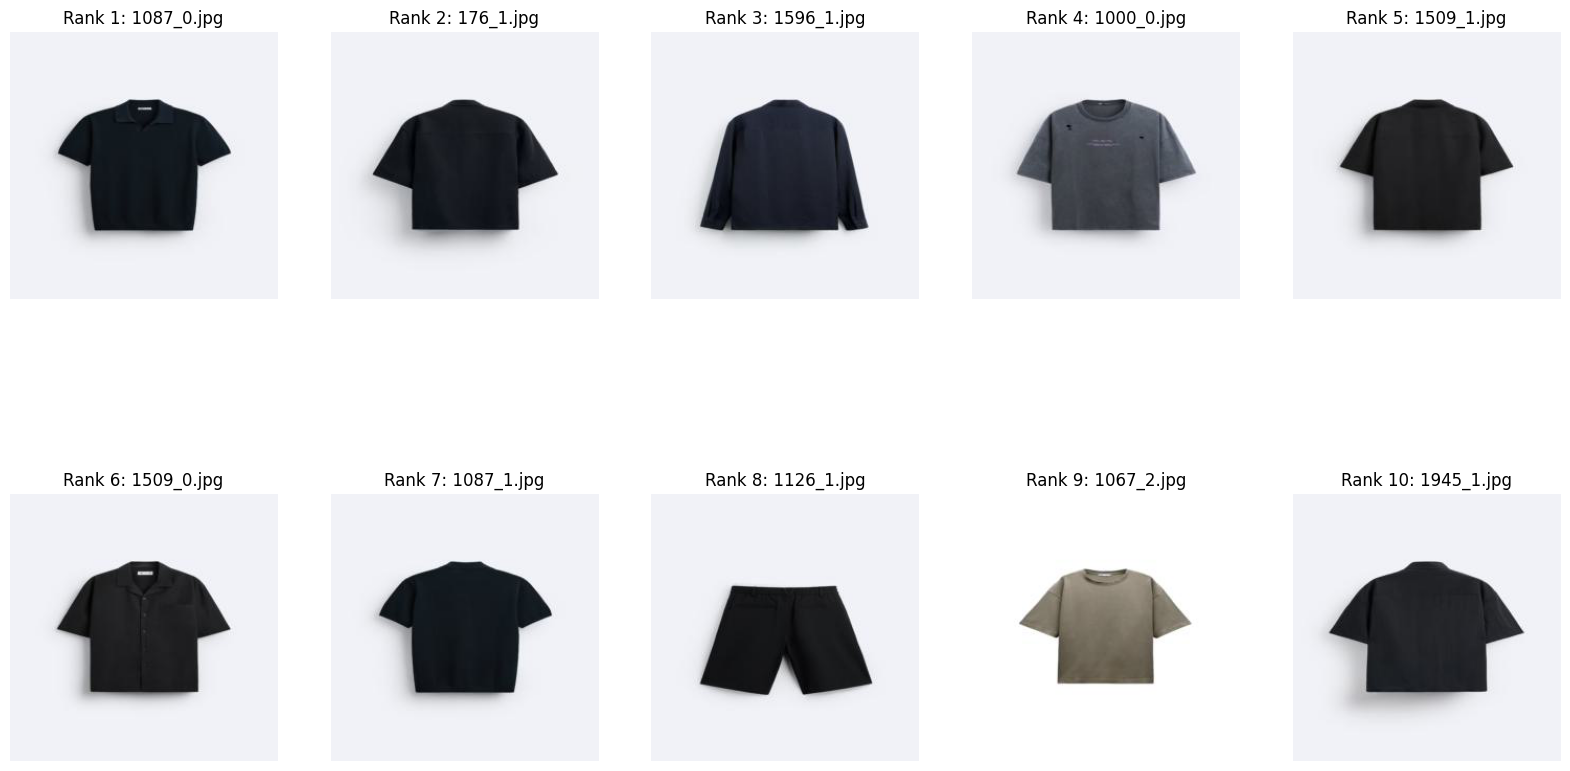

In [39]:
print("Top 10 similar images with pretrained model:")
similar_images = top_k_similar_images(pretrained_matrix, specific_image_name="1087_0.jpg", k=10)

Top 10 similar images with finetunned model:


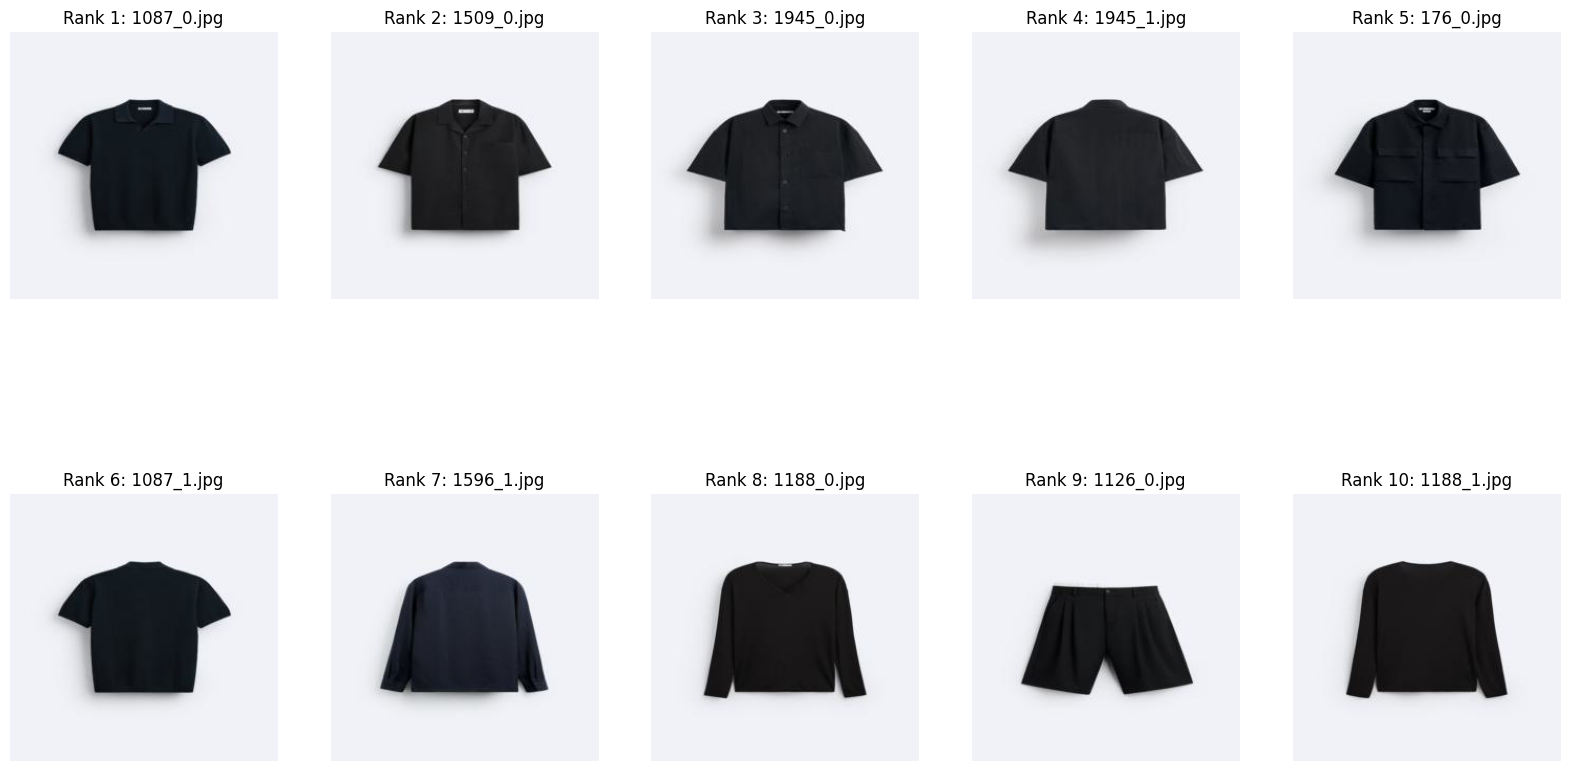

In [40]:
print("Top 10 similar images with finetunned model:")
similar_images = top_k_similar_images(finetunning_matrix, specific_image_name="1087_0.jpg", k=10)